In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col = "Id")
data_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = "Id")
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data = pd.concat([data_train.drop(columns = ["SalePrice"]),data_test])
data.shape

(2919, 79)

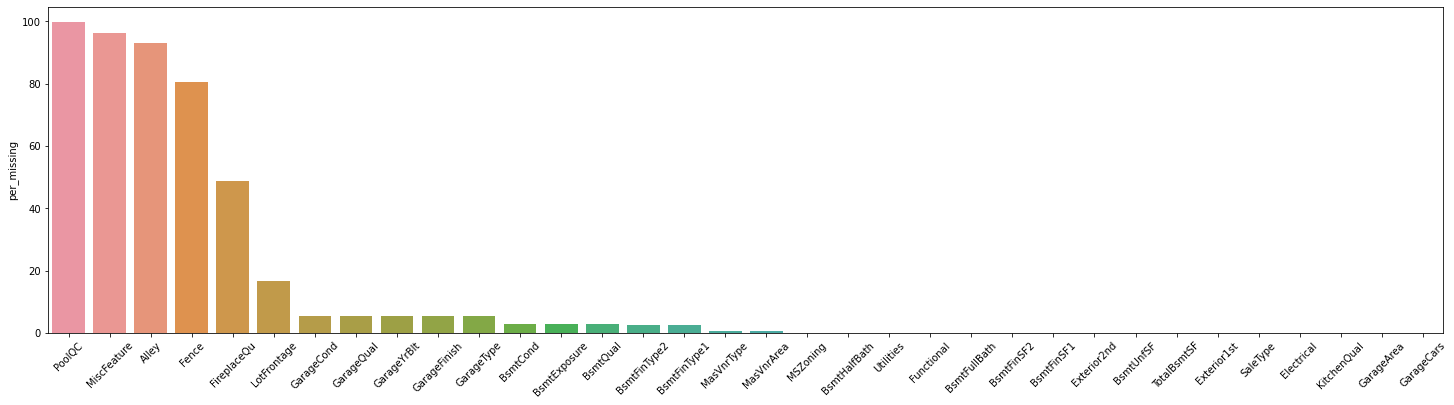

In [5]:
null_per = (data.isnull().sum()*100/2919).sort_values(ascending = False)
null_per = pd.DataFrame({"per_missing":null_per})
null_per = null_per[null_per["per_missing"] != 0]
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45)
sns.barplot(data = null_per, x=null_per.index, y="per_missing")

In [6]:
drop_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
data.drop(columns = drop_col, inplace = True)
data.shape

(2919, 74)

In [7]:
drop_garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars']
data.drop(columns = drop_garage, inplace = True)
data['GarageYrBlt'] = np.where(data['GarageYrBlt'].isnull(), data['YearBuilt'], data['GarageYrBlt'])
data['GarageArea'].fillna(0, inplace = True)
data.shape

(2919, 69)

In [8]:
bsmt_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in bsmt_col:
    if data[col].dtype == 'object':
        data[col].fillna('None', inplace = True)
    else:
        data[col].fillna(0, inplace = True)

data.shape

(2919, 69)

In [9]:
null_per = (data.isnull().sum()*100/2919).sort_values(ascending = False)
null_per = pd.DataFrame({"per_missing":null_per})
null_per = null_per[null_per["per_missing"] != 0]
null_per

,per_missing
LotFrontage,16.649538
MasVnrType,0.822199
MasVnrArea,0.787941
MSZoning,0.137033
Utilities,0.068517
Functional,0.068517
SaleType,0.034258
KitchenQual,0.034258
Exterior1st,0.034258
Exterior2nd,0.034258


In [10]:
from sklearn.impute import SimpleImputer

cols = ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Utilities', 'Functional', 'SaleType', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'Electrical']

for col in cols:
    if data[col].dtype == 'object':
        imputer = SimpleImputer(strategy = "most_frequent")
        imputer.fit(data_train[[col]])
        data[col] = imputer.transform(data[[col]])
    else:
        imputer = SimpleImputer()
        imputer.fit(data_train[[col]])
        data[col] = imputer.transform(data[[col]])

null_per = (data.isnull().sum()*100/2919)
null_per.sum()

0.0

In [11]:
OH_cat_cols = []
lab_cat_cols = []
for col in data.columns:
    if data[col].dtype == 'object':
        if data[col].nunique() <= 5:
            OH_cat_cols.append(col)
        else:
            lab_cat_cols.append(col)
print(len(OH_cat_cols),len(lab_cat_cols))

19 15


In [12]:
OH_cols = pd.get_dummies(data[OH_cat_cols])
data.drop(columns = OH_cat_cols, inplace = True)
data = pd.concat([data,OH_cols], axis = 1)
data.shape

(2919, 127)

In [13]:
from sklearn.preprocessing import OrdinalEncoder

lab_encoder = OrdinalEncoder()
data[lab_cat_cols] = lab_encoder.fit_transform(data[lab_cat_cols])

data.dtypes

MSSubClass          int64
LotFrontage       float64
LotArea             int64
Neighborhood      float64
Condition1        float64
                   ...   
KitchenQual_Gd      uint8
KitchenQual_TA      uint8
PavedDrive_N        uint8
PavedDrive_P        uint8
PavedDrive_Y        uint8
Length: 127, dtype: object

In [14]:
X_train = data[:data_train.shape[0]]
X_test = data[data_train.shape[0]:]
y_train = np.log(data_train["SalePrice"])
print(X_train.shape,data_train.shape,y_train.shape)
print(X_test.shape,data_test.shape)

(1460, 127) (1460, 80) (1460,)
(1459, 127) (1459, 79)


In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model_1 = XGBRegressor().fit(X_train, y_train, verbose = False)
predict_1 = model_1.predict(X_train)
error = 1000 * mean_absolute_error(predict_1,y_train)
error

7.880791897519095

In [16]:
from sklearn.model_selection import cross_val_score

for est in [70, 100, 150, 250, 500, 800, 1000, 1500]:
    print("n_est {}".format(est))
    for rate in [0.01, 0.025, 0.05, 0.1, 0.2]:
        xgb = XGBRegressor(n_estimators = est, learning_rate = rate)
        score = (-1000/5) * cross_val_score(xgb, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).sum()
        print(rate,score)

n_est 70
0.01 5708.142747693023
0.025 1964.488483203758
0.05 332.5898342648844
0.1 91.23696156374692
0.2 92.78552702962547
n_est 100
0.01 4224.230444996482
0.025 922.073208679431
0.05 115.92934626314096
0.1 88.48368290802337
0.2 92.6247182536984
n_est 150
0.01 2557.937905961677
0.025 275.05460926971256
0.05 88.28579382459867
0.1 88.01266355227716
0.2 92.76243204466415
n_est 250
0.01 939.8149360788155
0.025 92.34114781678463
0.05 86.20957420895579
0.1 87.92125832091506
0.2 92.85282013112702
n_est 500
0.01 119.89850597867746
0.025 85.762918154815
0.05 85.91709314219666
0.1 88.1398839444091
0.2 92.86198714615661
n_est 800
0.01 87.26908628716352
0.025 85.48914955671367
0.05 86.12045825745933
0.1 88.15539401860948
0.2 92.86198714615661
n_est 1000
0.01 86.08597140045255
0.025 85.3607818642299
0.05 86.16545190784011
0.1 88.15539401860948
0.2 92.86198714615661
n_est 1500
0.01 85.66287763033051
0.025 85.42320403562486
0.05 86.1596176442741
0.1 88.15539401860948
0.2 92.86198714615661


In [22]:
fmodel_1 = XGBRegressor(n_estimators = 1000, learning_rate = 0.025).fit(X_train, y_train, verbose = False)
fpredict_1 = fmodel_1.predict(X_train)
ferror = 1000 * mean_absolute_error(fpredict_1, y_train)
ferror

12.326382123751937

In [23]:
test_pred = fmodel_1.predict(X_test)
final = pd.DataFrame({"Id":X_test.index, "SalePrice":np.exp(test_pred)})
final.head()

,Id,SalePrice
0,1461,125303.601562
1,1462,165864.843750
2,1463,190534.390625
3,1464,188649.109375
4,1465,181019.234375


In [24]:
final.tail()

,Id,SalePrice
1454,2915,77384.976562
1455,2916,82703.257812
1456,2917,163152.015625
1457,2918,110643.539062
1458,2919,216393.953125


In [25]:
final.to_csv('./submission7.csv', index=False)